In [1]:
!pip install torch_geometric
!conda install -c pyg pytorch-sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 42.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=f39f6ba01e1d8a4371b8638b5dec6495c370e3703f36bfb2044b77443aa6dd59
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
/bin/bash: conda: command not found


In [15]:
import requests
import os
from torch_geometric.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

class HW3Dataset(Dataset):
    url = 'https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EUHUDSoVnitIrEA6ALsAK1QBpphP5jX3OmGyZAgnbUFo0A?download=1'

    def __init__(self, root, transform=None, pre_transform=None):
        super(HW3Dataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        file_url = self.url.replace(' ', '%20')
        response = requests.get(file_url)

        if response.status_code != 200:
            raise Exception(f"Failed to download the file, status code: {response.status_code}")

        with open(os.path.join(self.raw_dir, self.raw_file_names[0]), 'wb') as f:
            f.write(response.content)

    def process(self):
        raw_path = os.path.join(self.raw_dir, self.raw_file_names[0])
        data = torch.load(raw_path)
        torch.save(data, self.processed_paths[0])

    def len(self):
        return 1

    def get(self, idx):
        return torch.load(self.processed_paths[0])


In [16]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    for data in dataloader:
        optimizer.zero_grad()
        output = model(data.x)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()


In [18]:
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data in dataloader:
            output = model(data.x)
            _, predicted = torch.max(output, dim=1)
            predictions.append(predicted[data.val_mask].cpu().numpy())
            targets.append(data.y[data.val_mask].cpu().numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    accuracy = accuracy_score(targets, predictions)
    return accuracy


In [30]:
dataset = HW3Dataset(root='data/hw3/')
dataloader = DataLoader(dataset, batch_size=128)

In [35]:
model = Classifier(input_dim=128, hidden_dim=64, output_dim=40)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
del model,criterion,optimizer

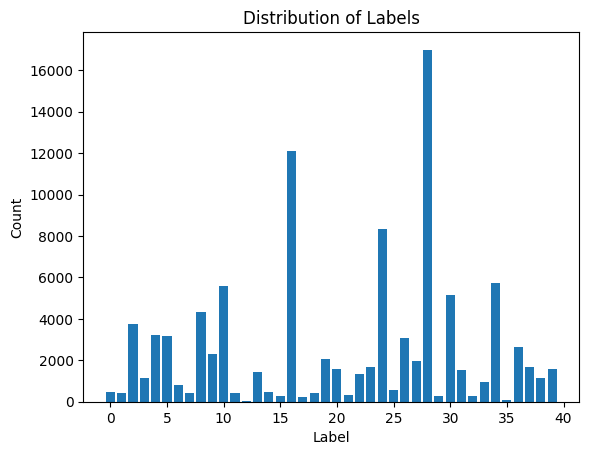

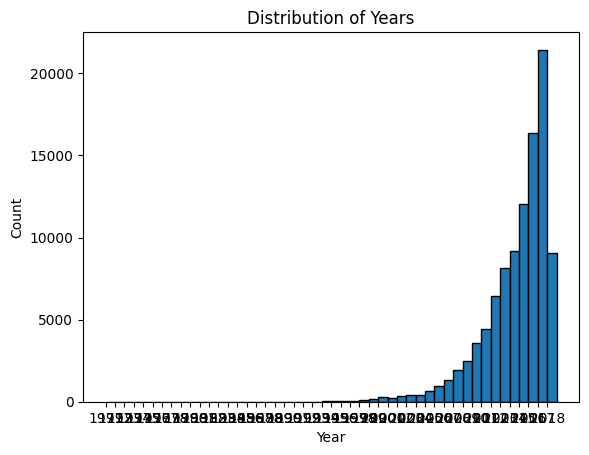

In [47]:
# Get the data
data = dataset.get(0)

# Flatten the nested array before plotting histogram of distribution of labels
label_counts = np.bincount(data.y.cpu().numpy().flatten())
labels = np.arange(len(label_counts))
plt.bar(labels, label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

# Extract the node_year attribute
node_years = data.node_year.cpu().numpy()

# Find the minimum and maximum year values
min_year = np.min(node_years)
max_year = np.max(node_years)

# Calculate the histogram of the distribution of years
year_counts, bins, _ = plt.hist(node_years.flatten(), bins=np.arange(min_year, max_year+2), edgecolor='black')

# Set the x-axis tick labels to display the range of years
plt.xticks(bins[:-1])

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Years')
plt.show()


In [36]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(dataset.num_features, 128, aggr="mean")
        self.conv2 = SAGEConv(128, 256, aggr="mean")
        self.conv3 = SAGEConv(256, 512, aggr="mean")
        self.conv4 = SAGEConv(512, 1024, aggr="mean")
        self.conv5 = SAGEConv(1024, dataset.num_classes, aggr="mean")

        self.dropout = torch.nn.Dropout(0.5)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.bn3 = torch.nn.BatchNorm1d(512)
        self.bn4 = torch.nn.BatchNorm1d(1024)

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.bn1(x)

        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.bn2(x)

        x = self.conv3(x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.bn3(x)

        x = self.conv4(x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.bn4(x)

        x = self.conv5(x, data.edge_index)
        return F.log_softmax(x, dim=1)


if __name__ == "__main__":
    dataset = HW3Dataset(root='data/hw3/')
    data = dataset[0]
    data.y = data.y.flatten()
    size = data.train_mask.shape[0] + data.val_mask.shape[0]
    max_index = data.train_mask.ravel()[-1].item()
    data.train_mask = torch.as_tensor([True if x <= max_index else False for x in range(size)])
    data.val_mask = torch.as_tensor([True if x > max_index else False for x in range(size)])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, data = Net().to(device), data.to(device)
    optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

    best_val_acc = test_acc = 0
    loss_function = CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_model = None

    for epoch in range(1, 100):
        model.train()
        optimizer.zero_grad()

        train_loss = loss_function(model(data)[data.train_mask], data.y[data.train_mask])

        train_loss.backward()

        optimizer.step()

        scheduler.step()

        model.eval()
        logits, accs = model(data), {'train_mask': 0, 'val_mask': 0}

        val_loss = loss_function(model(data)[data.val_mask], data.y[data.val_mask])

        for i, mask in data('train_mask', 'val_mask'):
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs[i] = acc

        if accs['val_mask'] > best_val_acc:
            best_val_acc = accs['val_mask']
            best_model = model.state_dict()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accs.append(accs['train_mask'])
        val_accs.append(accs['val_mask'])

        if epoch % 10 == 0:
            print('Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}'.format(epoch, accs['train_mask'], accs['val_mask']))

    torch.save(best_model, 'model.pt')

Epoch: 010, Train: 0.3967, Val: 0.3998
Epoch: 020, Train: 0.4772, Val: 0.4748
Epoch: 030, Train: 0.5576, Val: 0.5403
Epoch: 040, Train: 0.5801, Val: 0.5544
Epoch: 050, Train: 0.5934, Val: 0.5665
Epoch: 060, Train: 0.6023, Val: 0.5706
Epoch: 070, Train: 0.6076, Val: 0.5736
Epoch: 080, Train: 0.6099, Val: 0.5761
Epoch: 090, Train: 0.6106, Val: 0.5766


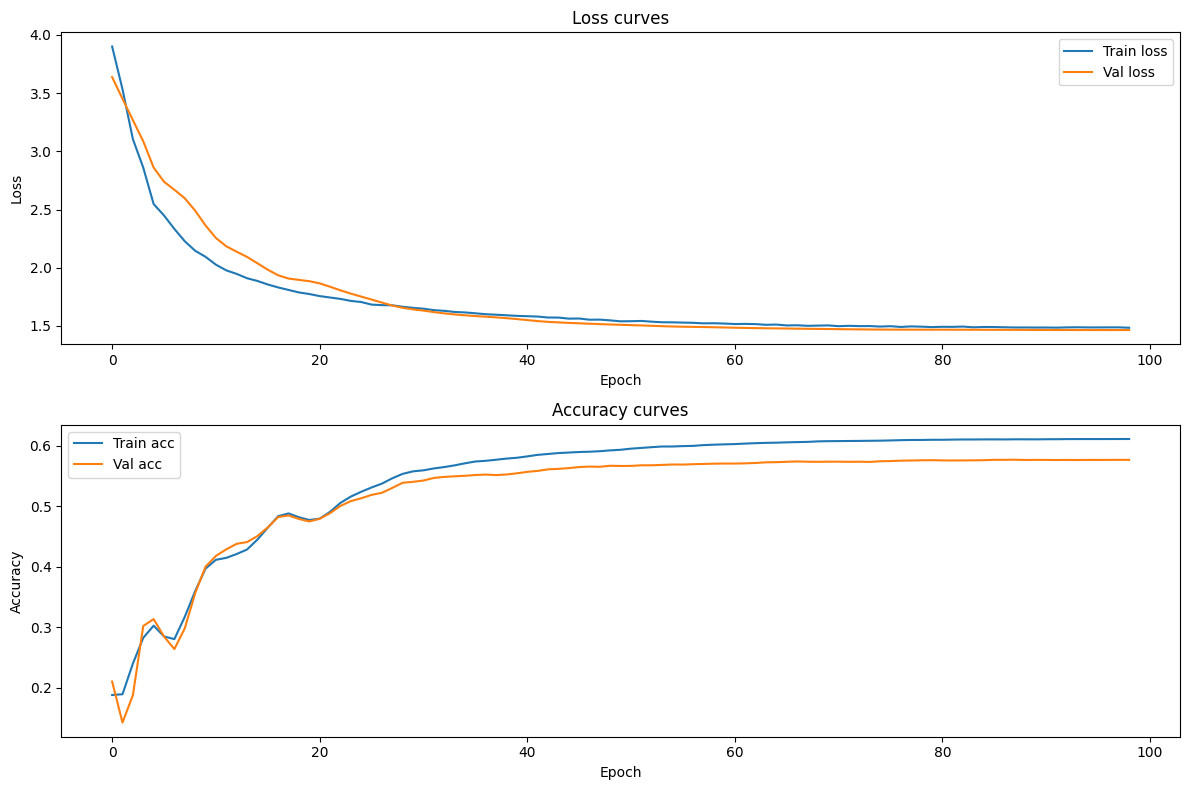

In [37]:
# plot the losses and accuracies for each epoch
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')

plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Train acc')
plt.plot(val_accs, label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy curves')

plt.tight_layout()
plt.show()
